<center> <h1 style="background-color:DarkSlateGray; color:white" >Sentiment Analysis for Amazon Reviews</h1> 

<center><img
src="https://m.media-amazon.com/images/G/41/social_share/amazon_logo._CB633269640_.png" style="width:50%;height:50%;">
</center>
    
<br>   

Hi ,
I'm Burak. In this project, we will aim to increase sales by analyzing the comments received on the products of a company that produces home textiles and daily wear focused on Amazon, and by improving its features according to the complaints it receives. In line with this goal, we will label the comments by making sentiment analysis and create a classification model with the tagged data.

**Let's Start!**

In [99]:
from warnings import filterwarnings
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from PIL import Image
from nltk.corpus import stopwords
from nltk.sentiment import SentimentIntensityAnalyzer
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, GridSearchCV, cross_validate,train_test_split
from sklearn.preprocessing import LabelEncoder
from textblob import Word, TextBlob
from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer

filterwarnings('ignore')
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 200)

<h3 style="color:DarkSlateGray" >1. Text Preprocessing</h3>

In [51]:
df = pd.read_excel("./datasets/amazon.xlsx")
df.head()

,Star,HelpFul,Title,Review
0,5,0,looks great,Happy with it
1,5,0,Pattern did not align between the two panels.,Good quality material however the panels are m...
2,5,0,Imagery is stretched. Still fun.,Product was fun for bedroom windows.<br />Imag...
3,5,0,Que se ven elegantes muy finas,Lo unico que me gustaria es que sean un poco ...
4,5,0,Wow great purchase,Great bang for the buck I can't believe the qu...


The data set consists of the comments made for a certain product group, the title of the comment, the number of stars and the variables that indicate how many people found the comment useful. We will focus on the Review variable.

<h4 style="color:DarkSlateGray" >Normalizing Case Folding</h4>

In [52]:
df['Review'] = df['Review'].str.lower()

<h4 style="color:DarkSlateGray" >Punctuations & Numbers</h4>

In [53]:
df['Review'] = df['Review'].str.replace('[^\w\s]', '')

In [54]:
df['Review'] = df['Review'].str.replace('\d', '')

In [55]:
df.head()

,Star,HelpFul,Title,Review
0,5,0,looks great,happy with it
1,5,0,Pattern did not align between the two panels.,good quality material however the panels are m...
2,5,0,Imagery is stretched. Still fun.,product was fun for bedroom windowsbr imagery ...
3,5,0,Que se ven elegantes muy finas,lo unico que me gustaria es que sean un poco ...
4,5,0,Wow great purchase,great bang for the buck i cant believe the qua...


<h4 style="color:DarkSlateGray" >Stopwords</h4>

In [56]:
import nltk
sw = stopwords.words('english')

df['Review'] = df['Review'].apply(lambda x: " ".join(x for x in str(x).split() if x not in sw))

<h4 style="color:DarkSlateGray" >Rarewords</h4>

In [58]:
temp_df = pd.Series(' '.join(df['Review']).split()).value_counts()

In [61]:
temp_df.sort_values(ascending=False)

curtains        1891
love            1312
room            1116
like            1037
beautiful        943
                ... 
hollermean         1
climb              1
coverings          1
murallarge         1
studioliving       1
Length: 6699, dtype: int64

In [65]:
drops = temp_df[temp_df <= 1]

df['Review'] = df['Review'].apply(lambda x: " ".join(x for x in x.split() if x not in drops))

<h4 style="color:DarkSlateGray" >Lemmatization</h4>

In [66]:
df['Review'] = df['Review'].apply(lambda x: " ".join([Word(word).lemmatize() for word in x.split()]))

<h3 style="color:DarkSlateGray" >2. Text Visualization</h3>

In [68]:
tf = df["Review"].apply(lambda x: pd.value_counts(x.split(" "))).sum(axis=0).reset_index()

In [69]:
tf.columns = ["words", "tf"]

tf.sort_values("tf", ascending=False)

,words,tf
58,curtain,2588.0
35,look,1531.0
108,love,1453.0
92,room,1129.0
152,like,1053.0
...,...,...
1941,nail,2.0
1942,salon,2.0
1945,write,2.0
1948,colorsbr,2.0


<h4 style="color:DarkSlateGray" >Barplot</h4>

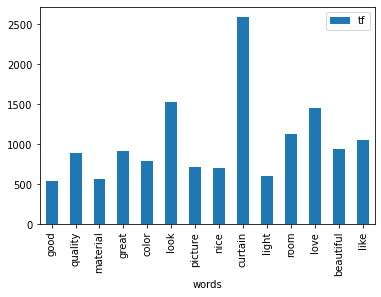

In [71]:
tf[tf["tf"] > 500].plot.bar(x="words", y="tf")
plt.show()

<h4 style="color:DarkSlateGray" >Word Cloud</h4>

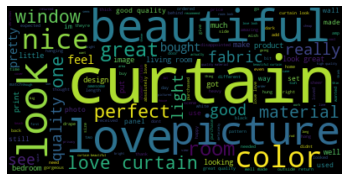

In [72]:
text = " ".join(i for i in df.Review)

wordcloud = WordCloud().generate(text)
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

<h3 style="color:DarkSlateGray" >3. Sentiment Analysis</h3>

In [74]:
df["Review"].head()

0                                                happy
1                  good quality material however panel
2    product fun bedroom windowsbr imagery bit stre...
3                              lo que e que un poco ma
4    great bang buck cant believe quality material ...
Name: Review, dtype: object

In [76]:
sia = SentimentIntensityAnalyzer()

In [81]:
df["Review"][0:5].apply(lambda x: sia.polarity_scores(x))

0    {'neg': 0.0, 'neu': 0.0, 'pos': 1.0, 'compound...
1    {'neg': 0.0, 'neu': 0.58, 'pos': 0.42, 'compou...
2    {'neg': 0.0, 'neu': 0.625, 'pos': 0.375, 'comp...
3    {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...
4    {'neg': 0.0, 'neu': 0.495, 'pos': 0.505, 'comp...
Name: Review, dtype: object

In [82]:
df["Review"][0:5].apply(lambda x: sia.polarity_scores(x)["compound"])

0    0.5719
1    0.4404
2    0.7184
3    0.0000
4    0.9042
Name: Review, dtype: float64

In [84]:
df["polarity_score"] = df["Review"].apply(lambda x: sia.polarity_scores(x)["compound"])

<h3 style="color:DarkSlateGray" >4. Feature Engineering</h3>

In [86]:
df["Review"][0:5].apply(lambda x: "pos" if sia.polarity_scores(x)["compound"] > 0 else "neg")

0    pos
1    pos
2    pos
3    neg
4    pos
Name: Review, dtype: object

In [88]:
df["sentiment_label"] = df["Review"].apply(lambda x: "pos" if sia.polarity_scores(x)["compound"] > 0 else "neg")

In [89]:
df["sentiment_label"].value_counts()

pos    4764
neg     847
Name: sentiment_label, dtype: int64

In [92]:
df.groupby("sentiment_label")["Star"].mean()

sentiment_label
neg    3.409681
pos    4.583333
Name: Star, dtype: float64

In [93]:
df["sentiment_label"] = LabelEncoder().fit_transform(df["sentiment_label"])

In [134]:
y = df["sentiment_label"]
X = df["Review"]

In [135]:
tf_idf_word_vectorizer = TfidfVectorizer()
X_tf_idf_word = tf_idf_word_vectorizer.fit_transform(X)

<h3 style="color:DarkSlateGray" >5. Sentiment Modeling</h3>

<h4 style="color:DarkSlateGray" >Logistic Regression</h4>

In [136]:
log_model = LogisticRegression().fit(X_tf_idf_word, y)

cross_val_score(log_model,
                X_tf_idf_word,
                y,
                scoring="accuracy",
                cv=5).mean()

0.8944925659084163

In [145]:
new_review = pd.Series("it was good but I am sure that it doesnt fit me")

In [146]:
new_review = TfidfVectorizer().fit(X).transform(new_review)

log_model.predict(new_review)

array([1])

In [147]:
random_review = pd.Series(df["Review"].sample(1).values)

In [149]:
random_review

0    anyone concerned dark versus light side curtai...
dtype: object

In [148]:
new_review2 = TfidfVectorizer().fit(X).transform(random_review)

log_model.predict(new_review2)

array([1])

<h4 style="color:DarkSlateGray" >Random Forest</h4>

In [153]:
rf_model = RandomForestClassifier().fit(X_tf_idf_word, y)
cross_val_score(rf_model, X_tf_idf_word, y, cv=5, n_jobs=-1).mean()

0.9158811942165354

Random forest provided 2% more accuracy than logistic regression. Let's continue with the random forest and do hyperparameter optimization.

<h4 style="color:DarkSlateGray" >Hyperparameter Optimization</h4>

In [155]:
rf_model = RandomForestClassifier(random_state=17)

rf_params = {"max_depth": [8, None],
             "max_features": [7, "auto"],
             "min_samples_split": [2, 5, 8],
             "n_estimators": [100, 200]}

rf_best_grid = GridSearchCV(rf_model,
                            rf_params,
                            cv=5,
                            n_jobs=-1,
                            verbose=1).fit(X_tf_idf_word, y)

rf_best_grid.best_params_

rf_final = rf_model.set_params(**rf_best_grid.best_params_, random_state=17).fit(X_tf_idf_word, y)


cross_val_score(rf_final, X_tf_idf_word, y, cv=5, n_jobs=-1).mean()

Fitting 5 folds for each of 24 candidates, totalling 120 fits


0.9183768966179526

<h3 style="color:DarkSlateGray" >We created our model with an accuracy rate of almost 92%.Thank you for your interest!</h3>